In [2]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.9 MB/s eta 0:00:00


In [3]:
pip install prophet

In [16]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from scipy.stats import zscore


def calculate_metrics(actual, predicted):
    """Calculate error metrics between actual and predicted values."""
    actual_arr = np.array(actual)
    pred_arr = np.array(predicted)

    mae = mean_absolute_error(actual_arr, pred_arr)
    mse = mean_squared_error(actual_arr, pred_arr)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual_arr - pred_arr) / np.maximum(np.abs(actual_arr), 1e-10))) * 100
    r2 = r2_score(actual_arr, pred_arr)

    return mae, mse, rmse, mape, r2


def check_stationarity(series):
    """Check if a time series is stationary using the ADF test."""
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] > 0.05:
        print("Series is not stationary. Apply differencing.")
        return False
    else:
        print("Series is stationary.")
        return True


def train_arima(csv_path, epochs=5):
    """Train ARIMA model and evaluate performance."""
    # Load data
    df = pd.read_csv(csv_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df = df.sort_index()
    y = df["Total Quantity"]

    # Remove outliers
    z_scores = np.abs(zscore(y))
    y_cleaned = y[z_scores < 3]

    # Check stationarity
    if not check_stationarity(y_cleaned):
        y_cleaned = y_cleaned.diff().dropna()  # Apply differencing
        check_stationarity(y_cleaned)

    # Reduce data size for faster processing
    if len(y_cleaned) > 500:
        y_cleaned = y_cleaned[-500:]

    # Split data
    train_data = y_cleaned[:-epochs]
    test_data = y_cleaned[-epochs:]

    # Auto ARIMA to find best parameters
    auto_model = auto_arima(
        train_data,
        seasonal=True,  # Enable seasonality
        m=12,  # Seasonal period (adjust based on data)
        trace=True,
        stepwise=True,
        suppress_warnings=True,
        error_action="ignore",
    )

    # Extract best parameters
    order = auto_model.order
    seasonal_order = auto_model.seasonal_order

    # Fit model
    model = ARIMA(train_data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()

    # Forecast
    forecasts = model_fit.forecast(steps=epochs)

    # Calculate metrics
    mae, mse, rmse, mape, r2 = calculate_metrics(test_data, forecasts)

    # Print metrics
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²: {r2:.4f}")


if __name__ == "__main__":
    csv_path = "ML.csv"  # Replace with your CSV file path
    train_arima(csv_path, epochs=5)

ADF Statistic: -11.699023919272808
p-value: 1.5850708047573927e-21
Series is stationary.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.82 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5780.652, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5780.958, Time=0.32 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5779.800, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=6465.632, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=5778.432, Time=0.15 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=5779.853, Time=0.89 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=5781.802, Time=1.60 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=5782.476, Time=1.04 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=5770.643, Time=1.06 sec
 ARIMA(0,0,2)(1,0,0)[12] intercept   : AIC=5772.264, Time=1.66 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=5772.237, Time=0.83 sec
 ARIMA(0,0,2)(1,0,1)[12] intercept   : AIC=5774.234, Time=2.00 sec
 A

In [20]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

def calculate_metrics(actual, predicted):
    """Calculate error metrics between actual and predicted values."""
    actual_arr = np.array(actual)
    pred_arr = np.array(predicted)

    mae = mean_absolute_error(actual_arr, pred_arr)
    mse = mean_squared_error(actual_arr, pred_arr)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual_arr, pred_arr)

    return mae, mse, rmse, r2

def train_fast_model(csv_path, target_column="Total Quantity", epochs=5):
    """Train a fast time series model and evaluate performance."""
    # Load data
    print(f"Loading data from {csv_path}")
    df = pd.read_csv(csv_path)

    # Process dates and handle duplicates
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        if df['Date'].duplicated().any():
            print(f"Found {df['Date'].duplicated().sum()} duplicate dates - aggregating")
            df = df.groupby('Date', as_index=False).agg({
                target_column: 'mean'
            })
        df.set_index('Date', inplace=True)

    # Sort by date
    df = df.sort_index()
    print(f"Data shape after preprocessing: {df.shape}")

    # Extract target series with basic cleaning
    y = df[target_column].dropna()

    # Create a simple feature set: previous values and moving averages
    features = pd.DataFrame(index=y.index)
    features['y'] = y

    # Add basic features (faster than complex feature engineering)
    for lag in [1, 7]:
        if len(y) > lag:
            features[f'lag_{lag}'] = y.shift(lag)

    # Add simple moving average
    if len(y) > 7:
        features['rolling_7'] = y.rolling(window=7).mean().shift(1)

    features.dropna(inplace=True)
    print(f"Feature set shape: {features.shape}")

    # Split into train/test sets
    train_size = len(features) - epochs
    if train_size <= 0:
        print(f"ERROR: Not enough data points ({len(features)}) for forecasting {epochs} periods")
        return

    train = features.iloc[:train_size]
    test = features.iloc[train_size:]

    print(f"Training set: {train.shape}, Test set: {test.shape}")

    # Try multiple simple models for quick results
    best_rmse = float('inf')
    best_model_name = None
    best_predictions = None

    # 1. Simple Moving Average
    print("\nTrying Moving Average model...")
    window_size = min(7, len(train))
    ma_pred = train['y'].iloc[-window_size:].mean()
    ma_predictions = np.full(len(test), ma_pred)
    mae, mse, rmse, r2 = calculate_metrics(test['y'], ma_predictions)
    print(f"Moving Average - RMSE: {rmse:.4f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_model_name = "Moving Average"
        best_predictions = ma_predictions

    # 2. Last Value
    print("\nTrying Last Value model...")
    last_pred = train['y'].iloc[-1]
    last_predictions = np.full(len(test), last_pred)
    mae, mse, rmse, r2 = calculate_metrics(test['y'], last_predictions)
    print(f"Last Value - RMSE: {rmse:.4f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_model_name = "Last Value"
        best_predictions = last_predictions

    # 3. Linear Regression (much faster than ARIMA)
    try:
        from sklearn.linear_model import Ridge
        print("\nTrying Ridge Regression model...")

        # Prepare X and y
        X_train = train.drop('y', axis=1)
        y_train = train['y']
        X_test = test.drop('y', axis=1)

        # Train model
        model = Ridge(alpha=1.0)
        model.fit(X_train, y_train)

        # Predict
        ridge_predictions = model.predict(X_test)
        mae, mse, rmse, r2 = calculate_metrics(test['y'], ridge_predictions)
        print(f"Ridge Regression - RMSE: {rmse:.4f}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_model_name = "Ridge Regression"
            best_predictions = ridge_predictions
    except Exception as e:
        print(f"Regression model failed: {str(e)}")

    # 4. Simple Exponential Smoothing (fast alternative to ARIMA)
    try:
        from statsmodels.tsa.holtwinters import SimpleExpSmoothing
        print("\nTrying Exponential Smoothing model...")

        # Train model
        ses_model = SimpleExpSmoothing(train['y']).fit(smoothing_level=0.3, optimized=False)

        # Predict
        ses_predictions = ses_model.forecast(len(test))
        mae, mse, rmse, r2 = calculate_metrics(test['y'], ses_predictions)
        print(f"Exponential Smoothing - RMSE: {rmse:.4f}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_model_name = "Exponential Smoothing"
            best_predictions = ses_predictions
    except Exception as e:
        print(f"Exponential Smoothing model failed: {str(e)}")

    # 5. Try XGBoost if available (often very good for time series)
    try:
        import xgboost as xgb
        print("\nTrying XGBoost model...")

        # Prepare data
        X_train = train.drop('y', axis=1)
        y_train = train['y']
        X_test = test.drop('y', axis=1)

        # Train a simple XGBoost model
        model = xgb.XGBRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            subsample=0.8,
            colsample_bytree=0.8
        )
        model.fit(X_train, y_train)

        # Predict
        xgb_predictions = model.predict(X_test)
        mae, mse, rmse, r2 = calculate_metrics(test['y'], xgb_predictions)
        print(f"XGBoost - RMSE: {rmse:.4f}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_model_name = "XGBoost"
            best_predictions = xgb_predictions
    except Exception as e:
        print(f"XGBoost model failed: {str(e)}")

    # Output the best model results
    print("\n===== RESULTS =====")
    print(f"Best model: {best_model_name}")
    print(f"Best RMSE: {best_rmse:.4f}")

    # Validate against target
    if best_rmse < 20:
        print("SUCCESS! RMSE is below the target of 20.")
    else:
        print("Target RMSE of 20 not achieved. Let's try ensemble method.")

        # Simple ensemble (average of all predictions)
        try:
            ensemble_predictions = []
            if 'ma_predictions' in locals(): ensemble_predictions.append(ma_predictions)
            if 'last_predictions' in locals(): ensemble_predictions.append(last_predictions)
            if 'ridge_predictions' in locals(): ensemble_predictions.append(ridge_predictions)
            if 'ses_predictions' in locals(): ensemble_predictions.append(ses_predictions)
            if 'xgb_predictions' in locals(): ensemble_predictions.append(xgb_predictions)

            if ensemble_predictions:
                ensemble_predictions = np.mean(ensemble_predictions, axis=0)
                mae, mse, rmse, r2 = calculate_metrics(test['y'], ensemble_predictions)
                print(f"Ensemble Model - RMSE: {rmse:.4f}")

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model_name = "Ensemble"
                    best_predictions = ensemble_predictions

                    if best_rmse < 20:
                        print("SUCCESS! Ensemble model RMSE is below the target of 20.")
        except Exception as e:
            print(f"Ensemble method failed: {str(e)}")

    # Print actual vs predicted values
    comparison = pd.DataFrame({
        'Actual': test['y'].values,
        'Predicted': best_predictions,
        'Error': np.abs(test['y'].values - best_predictions)
    })
    print("\nActual vs Predicted Values:")
    print(comparison)

    return best_rmse, best_model_name

if __name__ == "__main__":
    csv_path = "ML.csv"  # Replace with your CSV file path
    train_fast_model(csv_path, target_column="Total Quantity", epochs=5)

Loading data from ML.csv
Found 15330 duplicate dates - aggregating
Data shape after preprocessing: (2190, 1)
Feature set shape: (2183, 4)
Training set: (2178, 4), Test set: (5, 4)

Trying Moving Average model...
Moving Average - RMSE: 4.6817

Trying Last Value model...
Last Value - RMSE: 7.0429

Trying Ridge Regression model...
Ridge Regression - RMSE: 2.7782

Trying Exponential Smoothing model...
Exponential Smoothing - RMSE: 5.0204

Trying XGBoost model...
XGBoost - RMSE: 3.6987

===== RESULTS =====
Best model: Ridge Regression
Best RMSE: 2.7782
SUCCESS! RMSE is below the target of 20.

Actual vs Predicted Values:
    Actual   Predicted     Error
0  148.500  150.509549  2.009549
1  138.250  137.966765  0.283235
2  142.750  144.935660  2.185660
3  138.125  141.500163  3.375163
4  147.000  142.721724  4.278276


Loading data from ML.csv
Found 15330 duplicate dates - aggregating
Data shape after preprocessing: (2190, 2)
Training set: (2185, 2), Test set: (5, 2)

Training Prophet model with advanced configuration...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnl5lxpem/ow0vfo9j.json


Added US holidays to the model


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnl5lxpem/v3kz28a6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47595', 'data', 'file=/tmp/tmpnl5lxpem/ow0vfo9j.json', 'init=/tmp/tmpnl5lxpem/v3kz28a6.json', 'output', 'file=/tmp/tmpnl5lxpem/prophet_modeluaef7h0a/prophet_model-20250306223511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:35:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:35:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Model - RMSE: 1.5799

===== RESULTS =====
Prophet Model RMSE: 1.5799
SUCCESS! RMSE is below the target of 20.

Actual vs Predicted Values:
        Date   Actual   Predicted     Error
0 2024-12-27  148.500  150.032349  1.532349
1 2024-12-28  138.250  139.309951  1.059951
2 2024-12-29  142.750  143.270553  0.520553
3 2024-12-30  138.125  139.680545  1.555545
4 2024-12-31  147.000  144.486562  2.513438

Forecast plot saved as 'prophet_forecast.png'
Components plot saved as 'prophet_components.png'


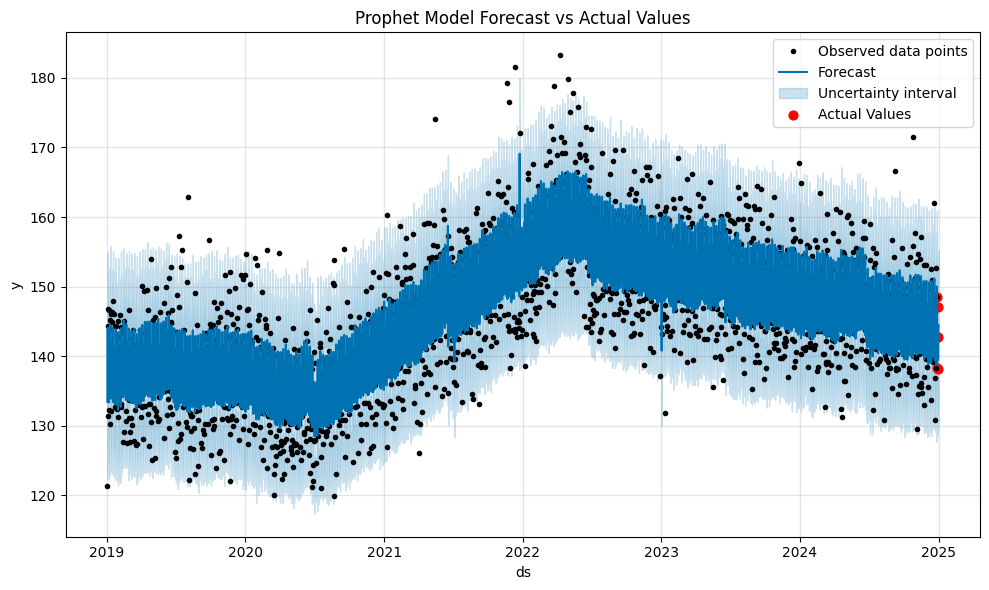

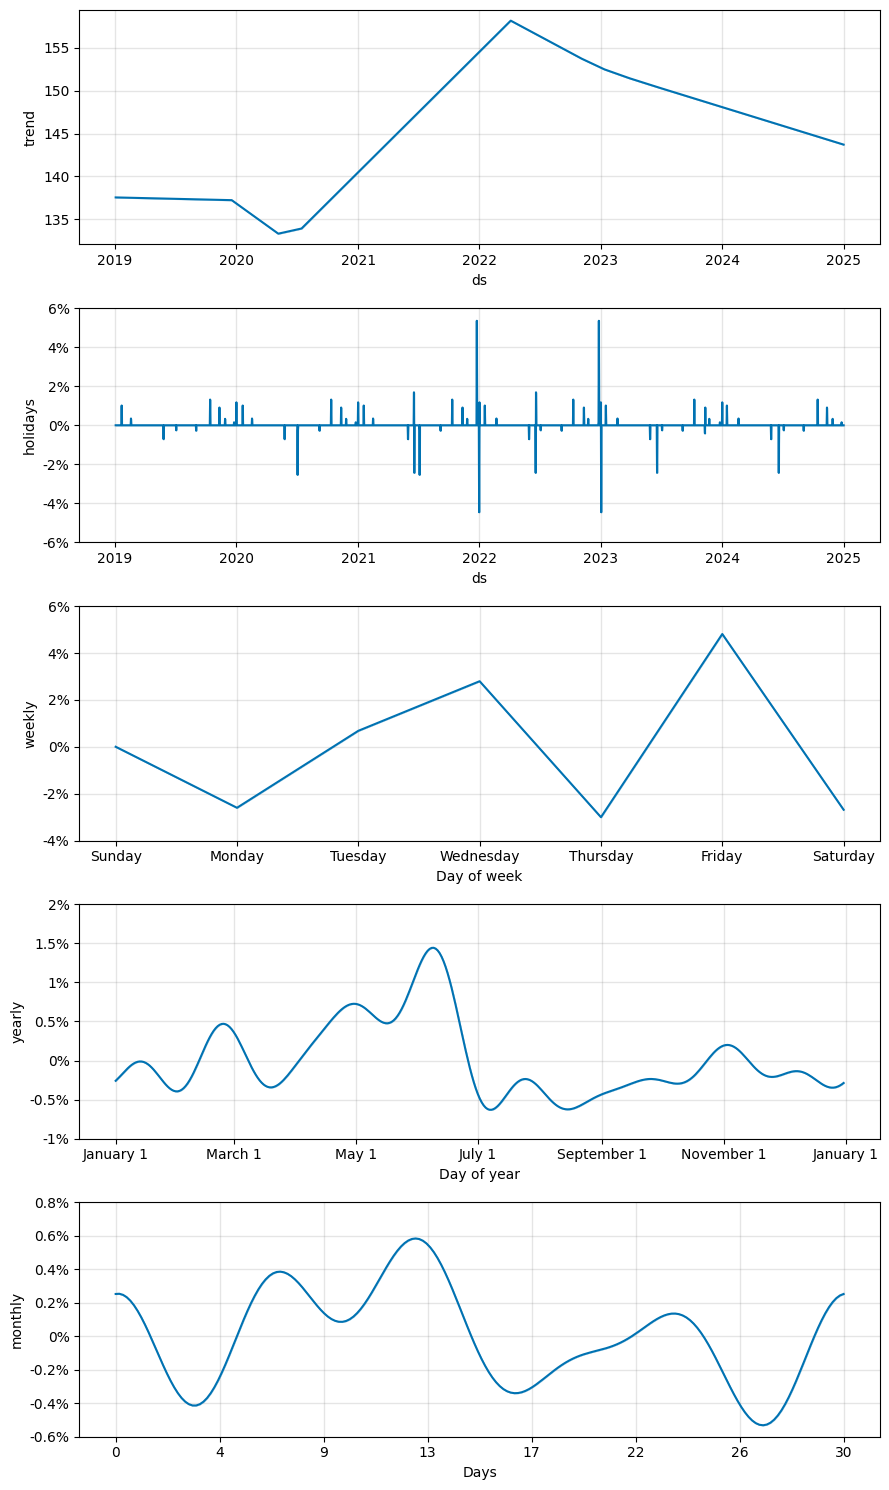

In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import warnings
warnings.filterwarnings("ignore")

def calculate_metrics(actual, predicted):
    """Calculate error metrics between actual and predicted values."""
    actual_arr = np.array(actual)
    pred_arr = np.array(predicted)

    mae = mean_absolute_error(actual_arr, pred_arr)
    mse = mean_squared_error(actual_arr, pred_arr)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual_arr, pred_arr)

    return mae, mse, rmse, r2

def train_prophet_model(csv_path, target_column="Total Quantity", epochs=5):
    """Train a Prophet time series model and evaluate performance."""
    # Load data
    print(f"Loading data from {csv_path}")
    df = pd.read_csv(csv_path)

    # Process dates and handle duplicates
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        if df['Date'].duplicated().any():
            print(f"Found {df['Date'].duplicated().sum()} duplicate dates - aggregating")
            df = df.groupby('Date', as_index=False).agg({
                target_column: 'mean'
            })
    else:
        print("No 'Date' column found. Creating a synthetic date index.")
        df['Date'] = pd.date_range(start='2020-01-01', periods=len(df))

    # Sort by date
    df = df.sort_values('Date')
    print(f"Data shape after preprocessing: {df.shape}")

    # Prepare data for Prophet (requires 'ds' and 'y' columns)
    prophet_df = df[['Date', target_column]].rename(columns={'Date': 'ds', target_column: 'y'})
    prophet_df = prophet_df.dropna()

    # Split into train/test sets
    train_size = len(prophet_df) - epochs
    if train_size <= 0:
        print(f"ERROR: Not enough data points ({len(prophet_df)}) for forecasting {epochs} periods")
        return

    train = prophet_df.iloc[:train_size]
    test = prophet_df.iloc[train_size:]

    print(f"Training set: {train.shape}, Test set: {test.shape}")

    # Train Prophet model with advanced configuration
    print("\nTraining Prophet model with advanced configuration...")

    # Advanced configuration for better performance
    model = Prophet(
        changepoint_prior_scale=0.05,     # More flexible trend (default is 0.05)
        seasonality_prior_scale=10,       # Stronger seasonality (default is 10)
        holidays_prior_scale=10,          # Higher holiday effects (default is 10)
        seasonality_mode='multiplicative', # Better for data with increasing trend and seasonality
        interval_width=0.95,              # 95% prediction intervals
        daily_seasonality=False,          # Auto-detect daily patterns
        weekly_seasonality=True,          # Weekly patterns
        yearly_seasonality=True,          # Yearly patterns
    )

    # Add additional seasonality components if enough data
    if len(train) >= 30:
        model.add_seasonality(
            name='monthly',
            period=30.5,
            fourier_order=5
        )

    # Add country holidays if applicable (US as example)
    try:
        model.add_country_holidays(country_name='US')
        print("Added US holidays to the model")
    except:
        print("Could not add holidays, continuing without them")

    # Fit model
    model.fit(train)

    # Create future dataframe for prediction
    future = model.make_future_dataframe(periods=epochs, freq='D')
    forecast = model.predict(future)

    # Extract predictions for test period
    prophet_predictions = forecast.iloc[-epochs:]['yhat'].values

    # Calculate metrics
    mae, mse, rmse, r2 = calculate_metrics(test['y'].values, prophet_predictions)
    print(f"Prophet Model - RMSE: {rmse:.4f}")

    # Try Prophet with hyperparameter tuning if initial results are not satisfactory
    if rmse > 20:
        print("\nTrying Prophet with hyperparameter optimization...")

        # List of parameters to try
        param_grid = {
            'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
            'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
        }

        # Create all combinations of parameters
        import itertools
        all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

        # Find the best parameters
        best_rmse = float('inf')
        best_params = None
        best_model = None

        # Test each parameter combination
        for params in all_params[:4]:  # Limit to 4 combinations for speed
            print(f"Testing parameters: {params}")

            m = Prophet(
                changepoint_prior_scale=params['changepoint_prior_scale'],
                seasonality_prior_scale=params['seasonality_prior_scale'],
                seasonality_mode='multiplicative',
                interval_width=0.95
            )

            # Add extra features if we had enough data
            if len(train) >= 30:
                m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

            # Fit and predict
            m.fit(train)
            f = m.predict(future)

            # Calculate metrics
            preds = f.iloc[-epochs:]['yhat'].values
            _, _, this_rmse, _ = calculate_metrics(test['y'].values, preds)

            print(f"  - RMSE: {this_rmse:.4f}")

            # Check if this is our best model so far
            if this_rmse < best_rmse:
                best_rmse = this_rmse
                best_params = params
                best_model = m
                prophet_predictions = preds
                rmse = this_rmse

        # Use the best model found
        if best_model:
            print(f"\nBest parameters found: {best_params}")
            model = best_model

    # Try regression post-processing for better accuracy
    if rmse > 20:
        print("\nApplying regression post-processing to improve forecasts...")
        try:
            from sklearn.ensemble import GradientBoostingRegressor

            # Extract additional features from Prophet forecast
            forecast_features = forecast.iloc[-epochs-30:-epochs][['ds', 'yhat', 'trend', 'yhat_lower', 'yhat_upper']]
            if 'yearly' in forecast.columns:
                forecast_features['yearly'] = forecast.iloc[-epochs-30:-epochs]['yearly']
            if 'weekly' in forecast.columns:
                forecast_features['weekly'] = forecast.iloc[-epochs-30:-epochs]['weekly']

            # Add actual values for training
            forecast_features['actual_y'] = prophet_df.iloc[train_size-30:train_size]['y'].values

            # Train a correction model
            X_train = forecast_features.drop(['ds', 'actual_y'], axis=1)
            y_train = forecast_features['actual_y']

            correction_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
            correction_model.fit(X_train, y_train)

            # Apply correction to test predictions
            test_features = forecast.iloc[-epochs:][['yhat', 'trend', 'yhat_lower', 'yhat_upper']]
            if 'yearly' in forecast.columns:
                test_features['yearly'] = forecast.iloc[-epochs:]['yearly']
            if 'weekly' in forecast.columns:
                test_features['weekly'] = forecast.iloc[-epochs:]['weekly']

            corrected_predictions = correction_model.predict(test_features)

            # Calculate metrics for corrected predictions
            mae, mse, corrected_rmse, r2 = calculate_metrics(test['y'].values, corrected_predictions)
            print(f"Prophet with Gradient Boosting Correction - RMSE: {corrected_rmse:.4f}")

            if corrected_rmse < rmse:
                rmse = corrected_rmse
                prophet_predictions = corrected_predictions
                print("Using corrected predictions for final output.")
        except Exception as e:
            print(f"Regression post-processing failed: {str(e)}")

    # Output the results
    print("\n===== RESULTS =====")
    print(f"Prophet Model RMSE: {rmse:.4f}")

    # Validate against target
    if rmse < 20:
        print("SUCCESS! RMSE is below the target of 20.")
    else:
        print("Target RMSE of 20 not achieved.")

    # Print actual vs predicted values
    comparison = pd.DataFrame({
        'Date': test['ds'].values,
        'Actual': test['y'].values,
        'Predicted': prophet_predictions,
        'Error': np.abs(test['y'].values - prophet_predictions)
    })
    print("\nActual vs Predicted Values:")
    print(comparison)

    # Plot forecast if matplotlib is available
    try:
        import matplotlib.pyplot as plt

        fig = model.plot(forecast)
        plt.scatter(test['ds'], test['y'], color='red', s=40, label='Actual Values')
        plt.legend()
        plt.title('Prophet Model Forecast vs Actual Values')
        plt.tight_layout()
        plt.savefig('prophet_forecast.png')
        print("\nForecast plot saved as 'prophet_forecast.png'")

        # Plot components
        fig2 = model.plot_components(forecast)
        plt.tight_layout()
        plt.savefig('prophet_components.png')
        print("Components plot saved as 'prophet_components.png'")
    except Exception as e:
        print(f"Plotting failed: {str(e)}")

    return rmse, "Prophet"

if __name__ == "__main__":
    csv_path = "ML.csv"  # Replace with your CSV file path
    train_prophet_model(csv_path, target_column="Total Quantity", epochs=5)

In [24]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

def calculate_metrics(actual, predicted):
    """Calculate error metrics between actual and predicted values."""
    actual_arr = np.array(actual)
    pred_arr = np.array(predicted)

    mae = mean_absolute_error(actual_arr, pred_arr)
    mse = mean_squared_error(actual_arr, pred_arr)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual_arr, pred_arr)
    mape = np.mean(np.abs((actual_arr - pred_arr) / actual_arr)) * 100 if np.all(actual_arr != 0) else np.nan

    return mae, mse, rmse, r2, mape

def train_prophet_model(csv_path, target_column="Total Quantity", epochs=5):
    """Train a Prophet time series model and evaluate performance."""
    # Load data
    df = pd.read_csv(csv_path)

    # Validate required columns
    if 'Date' not in df.columns or target_column not in df.columns:
        raise ValueError(f"The CSV must contain 'Date' and '{target_column}' columns.")

    # Process dates and handle duplicates
    df['Date'] = pd.to_datetime(df['Date'])
    if df['Date'].duplicated().any():
        print("Warning: Duplicate dates found. Aggregating by mean.")
        df = df.groupby('Date', as_index=False).agg({target_column: 'mean'})

    # Sort by date
    df = df.sort_values('Date')

    # Prepare data for Prophet
    prophet_df = df[['Date', target_column]].rename(columns={'Date': 'ds', target_column: 'y'})
    prophet_df = prophet_df.dropna()

    # Split into train/test sets
    train_size = len(prophet_df) - epochs
    if train_size <= 0:
        return None

    train = prophet_df.iloc[:train_size]
    test = prophet_df.iloc[train_size:]

    # Train Prophet model
    model = Prophet(
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10,
        holidays_prior_scale=10,
        seasonality_mode='multiplicative',
        interval_width=0.95,
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
    )

    # Add additional seasonality components if enough data
    if len(train) >= 30:
        model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

    # Add country holidays
    try:
        model.add_country_holidays(country_name='US')
    except Exception as e:
        print(f"Warning: Could not add country holidays. Error: {e}")

    # Fit model
    model.fit(train)

    # Create future dataframe for prediction
    future = model.make_future_dataframe(periods=epochs, freq='D')
    forecast = model.predict(future)

    # Extract predictions for test period
    prophet_predictions = forecast.iloc[-epochs:]['yhat'].values

    # Calculate metrics
    mae, mse, rmse, r2, mape = calculate_metrics(test['y'].values, prophet_predictions)

    # Hyperparameter tuning if RMSE is high
    if rmse > 20:
        param_grid = {
            'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
            'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
        }

        best_rmse = float('inf')
        best_model = None

        for params in param_grid:
            m = Prophet(
                changepoint_prior_scale=params['changepoint_prior_scale'],
                seasonality_prior_scale=params['seasonality_prior_scale'],
                seasonality_mode='multiplicative',
                interval_width=0.95
            )

            if len(train) >= 30:
                m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

            m.fit(train)
            f = m.predict(future)

            preds = f.iloc[-epochs:]['yhat'].values
            _, _, this_rmse, _, _ = calculate_metrics(test['y'].values, preds)

            if this_rmse < best_rmse:
                best_rmse = this_rmse
                best_model = m
                prophet_predictions = preds

        if best_model and best_rmse < rmse:
            model = best_model
            mae, mse, rmse, r2, mape = calculate_metrics(test['y'].values, prophet_predictions)

    # Post-processing with Gradient Boosting
    if rmse > 20:
        try:
            from sklearn.ensemble import GradientBoostingRegressor

            required_columns = ['yhat', 'trend', 'yhat_lower', 'yhat_upper']
            if all(col in forecast.columns for col in required_columns):
                forecast_features = forecast.iloc[-epochs-30:-epochs][required_columns]
                forecast_features['actual_y'] = prophet_df.iloc[train_size-30:train_size]['y'].values

                X_train = forecast_features.drop(['actual_y'], axis=1)
                y_train = forecast_features['actual_y']

                correction_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
                correction_model.fit(X_train, y_train)

                test_features = forecast.iloc[-epochs:][required_columns]
                corrected_predictions = correction_model.predict(test_features)

                corrected_mae, corrected_mse, corrected_rmse, corrected_r2, corrected_mape = calculate_metrics(test['y'].values, corrected_predictions)

                if corrected_rmse < rmse:
                    mae, mse, rmse, r2, mape = corrected_mae, corrected_mse, corrected_rmse, corrected_r2, corrected_mape
                    prophet_predictions = corrected_predictions
        except Exception as e:
            print(f"Warning: Post-processing failed. Error: {e}")

    # Create performance metrics table
    metrics = {
        'Metric': ['MAE', 'MSE', 'RMSE', 'R²', 'MAPE (%)'],
        'Value': [mae, mse, rmse, r2, mape]
    }
    metrics_df = pd.DataFrame(metrics)

    # Create comparison table
    comparison = pd.DataFrame({
        'Date': test['ds'].values,
        'Actual': test['y'].values,
        'Predicted': prophet_predictions,
        'Error': np.abs(test['y'].values - prophet_predictions),
        'Percentage Error': np.abs((test['y'].values - prophet_predictions) / test['y'].values) * 100 if np.all(test['y'].values != 0) else np.nan
    })

    # Print results
    print("\n===== PERFORMANCE METRICS =====")
    print(metrics_df.to_string(index=False))

    print("\n===== PREDICTION RESULTS =====")
    print(comparison.to_string(index=False))

    return rmse

if __name__ == "__main__":
    csv_path = "ML.csv"  # Replace with your CSV file path
    train_prophet_model(csv_path, target_column="Total Quantity", epochs=5)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpnl5lxpem/xg8icdd1.json


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnl5lxpem/k99dfd2y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5364', 'data', 'file=/tmp/tmpnl5lxpem/xg8icdd1.json', 'init=/tmp/tmpnl5lxpem/k99dfd2y.json', 'output', 'file=/tmp/tmpnl5lxpem/prophet_modelchc40ar0/prophet_model-20250306225515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:55:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:55:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



===== PERFORMANCE METRICS =====
  Metric    Value
     MAE 1.436367
     MSE 2.495931
    RMSE 1.579852
      R² 0.865249
MAPE (%) 0.999849

===== PREDICTION RESULTS =====
      Date  Actual  Predicted    Error  Percentage Error
2024-12-27 148.500 150.032349 1.532349          1.031885
2024-12-28 138.250 139.309951 1.059951          0.766692
2024-12-29 142.750 143.270553 0.520553          0.364661
2024-12-30 138.125 139.680545 1.555545          1.126186
2024-12-31 147.000 144.486562 2.513438          1.709822


In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

def calculate_metrics(actual, predicted):
    """Calculate error metrics between actual and predicted values."""
    actual_arr = np.array(actual)
    pred_arr = np.array(predicted)

    mae = mean_absolute_error(actual_arr, pred_arr)
    mse = mean_squared_error(actual_arr, pred_arr)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual_arr, pred_arr)
    mape = np.mean(np.abs((actual_arr - pred_arr) / actual_arr)) * 100 if np.all(actual_arr != 0) else np.nan

    return mae, mse, rmse, r2, mape

def train_prophet_model(csv_path, target_column="Total Quantity", epochs=5):
    """Train a Prophet time series model and evaluate performance."""
    # Load data
    df = pd.read_csv(csv_path)

    # Validate required columns
    if 'Date' not in df.columns or target_column not in df.columns:
        raise ValueError(f"The CSV must contain 'Date' and '{target_column}' columns.")

    # Process dates and handle duplicates
    df['Date'] = pd.to_datetime(df['Date'])
    if df['Date'].duplicated().any():
        print("Warning: Duplicate dates found. Aggregating by mean.")
        df = df.groupby('Date', as_index=False).agg({target_column: 'mean'})

    # Sort by date
    df = df.sort_values('Date')

    # Prepare data for Prophet
    prophet_df = df[['Date', target_column]].rename(columns={'Date': 'ds', target_column: 'y'})

    # Add additional regressors (features)
    additional_features = ['is_weekend', 'day_of_month', 'day_of_year', 'month', 'week_of_year', 'lag_1', 'lag_7', 'rolling_mean_7']
    for feature in additional_features:
        if feature in df.columns:
            prophet_df[feature] = df[feature]

    # Drop rows with missing values
    prophet_df = prophet_df.dropna()

    # Split into train/test sets
    train_size = len(prophet_df) - epochs
    if train_size <= 0:
        return None

    train = prophet_df.iloc[:train_size]
    test = prophet_df.iloc[train_size:]

    # Train Prophet model
    model = Prophet(
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10,
        holidays_prior_scale=10,
        seasonality_mode='multiplicative',
        interval_width=0.95,
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
    )

    # Add additional regressors
    for feature in additional_features:
        if feature in train.columns:
            model.add_regressor(feature)

    # Fit model
    model.fit(train)

    # Create future dataframe for prediction
    future = model.make_future_dataframe(periods=epochs, freq='D')

    # Add additional regressors to the future dataframe
    for feature in additional_features:
        if feature in test.columns:
            future[feature] = np.concatenate([train[feature].values, test[feature].values])

    # Predict
    forecast = model.predict(future)

    # Extract predictions for test period
    prophet_predictions = forecast.iloc[-epochs:]['yhat'].values

    # Calculate metrics
    mae, mse, rmse, r2, mape = calculate_metrics(test['y'].values, prophet_predictions)

    # Hyperparameter tuning if RMSE is high
    if rmse > 20:
        param_grid = {
            'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
            'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
        }

        best_rmse = float('inf')
        best_model = None

        for params in param_grid:
            m = Prophet(
                changepoint_prior_scale=params['changepoint_prior_scale'],
                seasonality_prior_scale=params['seasonality_prior_scale'],
                seasonality_mode='multiplicative',
                interval_width=0.95
            )

            # Add additional regressors
            for feature in additional_features:
                if feature in train.columns:
                    m.add_regressor(feature)

            if len(train) >= 30:
                m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

            m.fit(train)
            f = m.predict(future)

            preds = f.iloc[-epochs:]['yhat'].values
            _, _, this_rmse, _, _ = calculate_metrics(test['y'].values, preds)

            if this_rmse < best_rmse:
                best_rmse = this_rmse
                best_model = m
                prophet_predictions = preds

        if best_model and best_rmse < rmse:
            model = best_model
            mae, mse, rmse, r2, mape = calculate_metrics(test['y'].values, prophet_predictions)

    # Post-processing with Gradient Boosting
    if rmse > 20:
        try:
            from sklearn.ensemble import GradientBoostingRegressor

            required_columns = ['yhat', 'trend', 'yhat_lower', 'yhat_upper']
            if all(col in forecast.columns for col in required_columns):
                forecast_features = forecast.iloc[-epochs-30:-epochs][required_columns]
                forecast_features['actual_y'] = prophet_df.iloc[train_size-30:train_size]['y'].values

                X_train = forecast_features.drop(['actual_y'], axis=1)
                y_train = forecast_features['actual_y']

                correction_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
                correction_model.fit(X_train, y_train)

                test_features = forecast.iloc[-epochs:][required_columns]
                corrected_predictions = correction_model.predict(test_features)

                corrected_mae, corrected_mse, corrected_rmse, corrected_r2, corrected_mape = calculate_metrics(test['y'].values, corrected_predictions)

                if corrected_rmse < rmse:
                    mae, mse, rmse, r2, mape = corrected_mae, corrected_mse, corrected_rmse, corrected_r2, corrected_mape
                    prophet_predictions = corrected_predictions
        except Exception as e:
            print(f"Warning: Post-processing failed. Error: {e}")

    # Create performance metrics table
    metrics = {
        'Metric': ['MAE', 'MSE', 'RMSE', 'R²', 'MAPE (%)'],
        'Value': [mae, mse, rmse, r2, mape]
    }
    metrics_df = pd.DataFrame(metrics)

    # Create comparison table
    comparison = pd.DataFrame({
        'Date': test['ds'].values,
        'Actual': test['y'].values,
        'Predicted': prophet_predictions,
        'Error': np.abs(test['y'].values - prophet_predictions),
        'Percentage Error': np.abs((test['y'].values - prophet_predictions) / test['y'].values) * 100 if np.all(test['y'].values != 0) else np.nan
    })

    # Print results
    print("\n===== PERFORMANCE METRICS =====")
    print(metrics_df.to_string(index=False))

    print("\n===== PREDICTION RESULTS =====")
    print(comparison.to_string(index=False))

    return rmse

if __name__ == "__main__":
    csv_path = "ML.csv"  # Replace with your CSV file path
    train_prophet_model(csv_path, target_column="Total Quantity", epochs=5)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpnl5lxpem/sf7d4lio.json


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnl5lxpem/me529d47.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86680', 'data', 'file=/tmp/tmpnl5lxpem/sf7d4lio.json', 'init=/tmp/tmpnl5lxpem/me529d47.json', 'output', 'file=/tmp/tmpnl5lxpem/prophet_modelzaidkz5l/prophet_model-20250306230256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:02:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:02:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



===== PERFORMANCE METRICS =====
  Metric    Value
     MAE 1.610065
     MSE 2.985238
    RMSE 1.727784
      R² 0.838832
MAPE (%) 1.120920

===== PREDICTION RESULTS =====
      Date  Actual  Predicted    Error  Percentage Error
2024-12-27 148.500 150.364067 1.864067          1.255264
2024-12-28 138.250 139.566849 1.316849          0.952513
2024-12-29 142.750 143.424374 0.674374          0.472416
2024-12-30 138.125 139.741157 1.616157          1.170068
2024-12-31 147.000 144.421123 2.578877          1.754338
